<a href="https://colab.research.google.com/github/als1379/Statistical-and-Mathematical-Methods-for-Artificial-Intelligence/blob/main/HW3/HW3_Optimization_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# ------------------------------------------------------------------
# 1. Utility Functions
# ------------------------------------------------------------------

def make_polynomial_features(X, degree):
    """
    Build [1, x, x^2, ..., x^degree] for each x in X.
    Returns array of shape (len(X), degree+1).
    """
    X = X.reshape(-1, 1)
    return np.hstack([X**i for i in range(degree + 1)])

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def gradient_descent(X, y, lr=0.01, epochs=3000):
    """
    Full-batch Gradient Descent.
    Returns parameter vector theta of shape (D,).
    """
    N, D = X.shape
    theta = np.zeros(D)
    for _ in range(epochs):
        y_pred = X @ theta
        grad = (2.0 / N) * (X.T @ (y_pred - y))
        theta -= lr * grad
    return theta

def stochastic_gradient_descent(X, y, lr=0.01, epochs=100, batch_size=16):
    """
    Stochastic Gradient Descent.
    Returns parameter vector theta of shape (D,).
    """
    N, D = X.shape
    theta = np.zeros(D)

    for _ in range(epochs):
        indices = np.random.permutation(N)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for start_idx in range(0, N, batch_size):
            end_idx = min(start_idx + batch_size, N)
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            y_pred = X_batch @ theta
            grad = (2.0 / len(X_batch)) * (X_batch.T @ (y_pred - y_batch))
            theta -= lr * grad
    return theta

# ------------------------------------------------------------------
# 2. Experiment Function (returns results, no plots yet)
# ------------------------------------------------------------------

def experiment_varying_degree(
    csv_large='poly_regression_large.csv',
    csv_small='poly_regression_small.csv',
    degrees=(1,2,3,4,5),
    lr=0.01,
    gd_epochs=3000,
    sgd_epochs=100,
    batch_size=16
):
    """
    1) Loads datasets.
    2) Splits the 'large' dataset into train/test (80/20).
    3) For each polynomial degree K:
       - Train via SGD (large train)
       - Train via Full-batch GD (large train)
       - Train on the entire small dataset
       - Evaluate each model on the large test set
    Returns:
        degrees_list, mses_sgd, mses_gd, mses_small
      where each is a list of length len(degrees).
    """
    # Read large dataset, split 80/20
    df_large = pd.read_csv(csv_large)
    X_large = df_large['x'].values
    y_large = df_large['y'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X_large, y_large, test_size=0.2, random_state=42
    )

    # Read small dataset (full set used for training)
    df_small = pd.read_csv(csv_small)
    X_small = df_small['x'].values
    y_small = df_small['y'].values

    # Prepare arrays to store results
    degrees_list = []
    mses_sgd = []
    mses_gd = []
    mses_small = []

    # Loop over each polynomial degree
    for K in degrees:
        # Build polynomial features for train/test (large)
        X_train_poly = make_polynomial_features(X_train, K)
        X_test_poly  = make_polynomial_features(X_test,  K)

        # 1) Train with SGD
        theta_sgd = stochastic_gradient_descent(
            X_train_poly, y_train, lr=lr,
            epochs=sgd_epochs, batch_size=batch_size
        )
        y_pred_sgd = X_test_poly @ theta_sgd
        mse_sgd = mean_squared_error(y_test, y_pred_sgd)

        # 2) Train with Full-batch GD
        theta_gd = gradient_descent(
            X_train_poly, y_train, lr=lr, epochs=gd_epochs
        )
        y_pred_gd = X_test_poly @ theta_gd
        mse_gd = mean_squared_error(y_test, y_pred_gd)

        # 3) Train on small dataset (full)
        X_small_poly = make_polynomial_features(X_small, K)
        poly = PolynomialFeatures(degree=K)

        model_small = LinearRegression(fit_intercept=False)
        # (fit_intercept=False) ensures the 1-column from PolynomialFeatures
        # acts as the intercept term.  Otherwise, we’d get a double intercept.

        model_small.fit(X_small_poly, y_small)
        y_pred_small = model_small.predict(X_test_poly)
        mse_sm = mean_squared_error(y_test, y_pred_small)

        # Store results
        degrees_list.append(K)
        mses_sgd.append(mse_sgd)
        mses_gd.append(mse_gd)
        mses_small.append(mse_sm)

    return degrees_list, mses_sgd, mses_gd, mses_small



In [2]:
def plot_mse_vs_degree(degrees, mses_sgd, mses_gd, mses_small):
    """
    Given arrays (or lists) of degrees vs. MSE values for three different
    model-training methods, plot them on a single figure.
    """
    plt.figure(figsize=(8,5))
    plt.plot(degrees, mses_sgd,    'o-', label='SGD (large)')
    plt.plot(degrees, mses_gd,     'o-', label='Full GD (large)')
    plt.plot(degrees, mses_small,  'o-', label='Trained on small')
    plt.xlabel('Polynomial Degree (K)')
    plt.ylabel('Mean Squared Error on Large Test Set')
    plt.title('MSE vs. Polynomial Degree')
    plt.grid(True)
    plt.legend()
    plt.show()


In [20]:
degs, mse_sgd_vals, mse_gd_vals, mse_small_vals = experiment_varying_degree(
    csv_large='/content/poly_regression_large.csv',
    csv_small='/content/poly_regression_small.csv',
    degrees=[1,2,3,4,5],
    lr=0.01,
    gd_epochs=3000,
    sgd_epochs=100,
    batch_size=16
)

# Print tabular results
print("Degree |  MSE (SGD)  |  MSE (GD)   | MSE (Small)")
print("-------+-------------+-------------+------------")
for d, sgd_mse, gd_mse, sm_mse in zip(degs, mse_sgd_vals, mse_gd_vals, mse_small_vals):
    print(f"{d:6d} | {sgd_mse:11.6f} | {gd_mse:11.6f} | {sm_mse:10.6f}")


Degree |  MSE (SGD)  |  MSE (GD)   | MSE (Small)
-------+-------------+-------------+------------
     1 |    0.032663 |    0.032592 |   0.032566
     2 |    0.037704 |    0.041035 |   0.022658
     3 |    0.030480 |    0.038497 |   0.009749
     4 |    0.021181 |    0.030520 |   0.009571
     5 |    0.015078 |    0.022792 |   0.009688


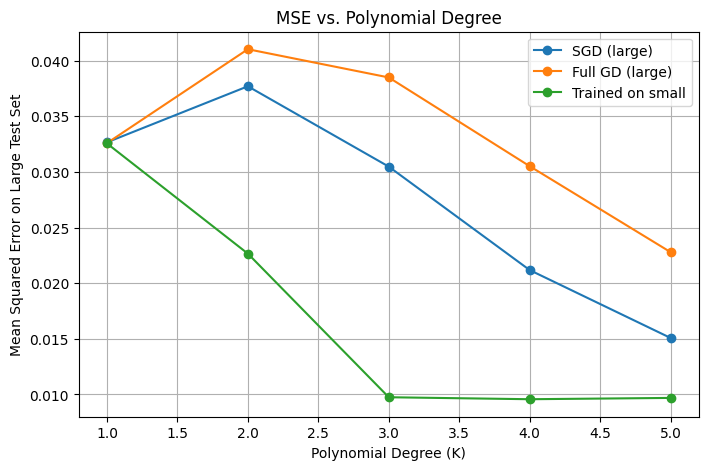

In [21]:
plot_mse_vs_degree(degs, mse_sgd_vals, mse_gd_vals, mse_small_vals)

# Compare actual weights with trained in degree 4

In [18]:
csv_large='/content/poly_regression_large.csv'
csv_small='/content/poly_regression_small.csv'
lr=0.01
gd_epochs=3000
sgd_epochs=100
batch_size=16

df_large = pd.read_csv(csv_large)
X_large = df_large['x'].values
y_large = df_large['y'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_large, y_large, test_size=0.2, random_state=42
)

# Read small dataset (full set used for training)
df_small = pd.read_csv(csv_small)
X_small = df_small['x'].values
y_small = df_small['y'].values

K = 4

# Loop over each polynomial degree
# Build polynomial features for train/test (large)
X_train_poly = make_polynomial_features(X_train, K)
X_test_poly  = make_polynomial_features(X_test,  K)

# 1) Train with SGD
theta_sgd = stochastic_gradient_descent(
    X_train_poly, y_train, lr=lr,
    epochs=sgd_epochs, batch_size=batch_size
)
y_pred_sgd = X_test_poly @ theta_sgd
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

# 2) Train with Full-batch GD
theta_gd = gradient_descent(
    X_train_poly, y_train, lr=lr, epochs=gd_epochs
)
y_pred_gd = X_test_poly @ theta_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)

# 3) Train on small dataset (full)
X_small_poly = make_polynomial_features(X_small, K)
poly = PolynomialFeatures(degree=K)

model_small = LinearRegression(fit_intercept=False)
print(X_small_poly.shape)
model_small.fit(X_small_poly, y_small)
y_pred_small = model_small.predict(X_test_poly)
mse_sm = mean_squared_error(y_test, y_pred_small)
theta_small = model_small.coef_
theta_star = np.array([0, 0, 4, 0, -3])

print("\n*** True parameter vector (theta_star) ***")
print(theta_star)

print("\n--- SGD on large dataset ---")
print("Learned params:", theta_sgd)
print("Test MSE:", mse_sgd)
print("Difference from true:", theta_sgd - theta_star)

print("\n--- Full-batch GD on large dataset ---")
print("Learned params:", theta_gd)
print("Test MSE:", mse_gd)
print("Difference from true:", theta_gd - theta_star)

print("\n--- Regression on small dataset ---")
print("Learned params:", theta_small)
print("Test MSE:", mse_sm)
print("Difference from true:", theta_small - theta_star)



(50, 5)

*** True parameter vector (theta_star) ***
[ 0  0  4  0 -3]

--- SGD on large dataset ---
Learned params: [-0.06490204  1.45273422  0.64910835 -0.08516069 -0.5955536 ]
Test MSE: 0.021258542384987256
Difference from true: [-0.06490204  1.45273422 -3.35089165 -0.08516069  2.4044464 ]

--- Full-batch GD on large dataset ---
Learned params: [ 0.01715353  1.17572446  0.56865088  0.03037345 -0.33896274]
Test MSE: 0.030519506514455796
Difference from true: [ 0.01715353  1.17572446 -3.43134912  0.03037345  2.66103726]

--- Regression on small dataset ---
Learned params: [ 0.03290773 -0.45977277  4.84291477  0.1721476  -3.66058933]
Test MSE: 0.009570856108518943
Difference from true: [ 0.03290773 -0.45977277  0.84291477  0.1721476  -0.66058933]
